# Image Captioning

## Build vocabulary

In [2]:
import nltk
import pickle
from collections import Counter
from pycocotools.coco import COCO

In [10]:
class Vocabulary(object):
    """Simple vocabulary wrapper."""
    
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0
    
    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1
    
    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]
    
    def __len__(self):
        return len(self.word2idx)

In [13]:
def build_vocab(json, threshold):
    """Build a simple vocabulary wrapper."""
    coco = COCO(json)
    counter = Counter()
    ids = coco.anns.keys()
    for i, id in enumerate(ids):
        caption = str(coco.anns[id]['caption'])
        tokens = nltk.tokenize.word_tokenize(caption.lower())
        counter.update(tokens)
        
        if (i + 1) % 100000 == 0:
            print('[{}/{}] Tokenized the captions.'.format(i + 1, len(ids)))
    
    # 単語頻度がthreshold以上の単語のみ使う
    words = [word for word, cnt in counter.items() if cnt >= threshold]
    
    # ボキャブラリを作成
    vocab = Vocabulary()
    vocab.add_word('<pad>')
    vocab.add_word('<start>')
    vocab.add_word('<end>')
    vocab.add_word('<unk>')
    
    for i, word in enumerate(words):
        vocab.add_word(word)
    
    return vocab

In [14]:
vocab = build_vocab(json='data/annotations/captions_train2014.json', threshold=4)

loading annotations into memory...
Done (t=0.73s)
creating index...
index created!
[100000/414113] Tokenized the captions.
[200000/414113] Tokenized the captions.
[300000/414113] Tokenized the captions.
[400000/414113] Tokenized the captions.


In [15]:
with open('./data/vocab.pkl', 'wb') as f:
    pickle.dump(vocab, f)

In [16]:
print('Total vocabulary size: {}'.format(len(vocab)))

Total vocabulary size: 9957


## Resize images

In [18]:
import os
from PIL import Image

In [17]:
def resize_image(image, size):
    """Resize an image to the given size."""
    return image.resize(size, Image.ANTIALIAS)

In [24]:
def resize_images(image_dir, output_dir, size):
    os.makedirs(output_dir, exist_ok=True)
    
    images = os.listdir(image_dir)
    num_images = len(images)
    for i, image in enumerate(images):
        with open(os.path.join(image_dir, image), 'rb') as f:
            with Image.open(f) as img:
                img = resize_image(img, size)
                img.save(os.path.join(output_dir, image), img.format)
        if (i + 1) % 1000 == 0:
            print('[{}/{}] Resized the images and saved into {}.'.format(i + 1, num_images, output_dir))

In [ ]:
resize_images('./data/train2014', './data/resized2014', (256, 256))

## Model

In [26]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence

In [30]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet152(pretrained=True)
        # 最後のFC層を削除
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
    
    def forward(self, images):
        with torch.no_grad():
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features

In [32]:
resnet = models.resnet152(pretrained=True)

In [33]:
resnet.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [305]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seq_length = max_seq_length
    
    def forward(self, features, captions, length):
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        packed = pack_padded_sequence(embeddings, length, batch_first=True)
        hiddens, _ = self.lstm(packed)
        outputs = self.linear(hiddens[0])
        return outputs

    def sample(self, features, states=None):
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seq_length):
            hiddens, states = self.lstm(inputs, states)
            outputs = self.linear(hiddens.squeeze(1))
            _, predicted = outputs.max(1)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)
            inputs = inputs.unsqueeze(1)
        sampled_ids = torch.stack(sampled_ids, 1)
        return sampled_ids

## DataLoader

In [38]:
import torch
import torchvision.transforms as transforms
import torch.utils.data as data
import os
import pickle
import numpy as np
import nltk
from PIL import Image
from pycocotools.coco import COCO

In [47]:
class CocoDataset(data.Dataset):
    def __init__(self, root, json, vocab, transform=None):
        self.root = root
        self.coco = COCO(json)
        self.ids = list(self.coco.anns.keys())
        self.vocab = vocab
        self.transform = transform
    
    def __getitem__(self, index):
        coco = self.coco
        vocab = self.vocab
        # アノテーションのID
        ann_id = self.ids[index]
        # キャプションと画像IDを取り出す
        caption = coco.anns[ann_id]['caption']
        img_id = coco.anns[ann_id]['image_id']
        path = coco.loadImgs(img_id)[0]['file_name']
        
        image = Image.open(os.path.join(self.root, path)).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        
        # キャプションを単語IDに変換
        tokens = nltk.tokenize.word_tokenize(str(caption).lower())
        caption = []
        caption.append(vocab('<start>'))
        caption.extend([vocab(token) for token in tokens])
        caption.append(vocab('<end>'))
        target = torch.Tensor(caption)
        return image, target

    def __len__(self):
        return len(self.ids)

In [50]:
coco = CocoDataset(root='./data/resized2014',
                   json='./data/annotations/captions_train2014.json',
                   vocab=vocab,
                   transform=None)

loading annotations into memory...
Done (t=0.66s)
creating index...
index created!


In [67]:
# 画像のサイズは一緒だが、キャプションの長さが異なるので普通にDataLoaderでバッチ化はできない
# collate_fn()を追加してバッチサイズを揃える
print(coco[0])
print(coco[1])

(<PIL.Image.Image image mode=RGB size=256x256 at 0x1A27B92B38>, tensor([  1.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,   2.]))
(<PIL.Image.Image image mode=RGB size=256x256 at 0x1A27B92C50>, tensor([  1.,   4.,  12.,  13.,  14.,   4.,  15.,   7.,  16.,  14.,
         17.,  18.,  19.,   2.]))


In [145]:
def collate_fn(data):
    # dataは (image, caption) のリスト（ミニバッチサイズ）
    # image: (3, 256, 256)
    # caption: (?) サイズは任意
    # captionの長さが長い順にソート
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions = zip(*data)

    # 画像をマージ
    # imageのtupleを4Dテンソルに変換
    images = torch.stack(images, 0)

    # キャプションをマージ
    lengths = [len(cap) for cap in captions]
    # ミニバッチ内の最長のキャプションに合わせる
    targets = torch.zeros(len(captions), max(lengths)).long()
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]

    return images, targets, lengths

In [146]:
def get_loader(root, json, vocab, transform, batch_size, shuffle, num_workers):
    coco = CocoDataset(root, json, vocab, transform)
    data_loader = torch.utils.data.DataLoader(dataset=coco,
                                              batch_size=batch_size,
                                              shuffle=shuffle,
                                              num_workers=num_workers,
                                              collate_fn=collate_fn)
    return data_loader

In [168]:
transform = transforms.Compose([
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))])

data_loader = get_loader(root='./data/resized2014',
                         json='./data/annotations/captions_train2014.json',
                         vocab=vocab,
                         transform=transform,
                         batch_size=16,
                         shuffle=True,
                         num_workers=0)

images, targets, lengths = iter(loader).next()

loading annotations into memory...
Done (t=0.70s)
creating index...
index created!


In [169]:
images.size()

torch.Size([16, 3, 224, 224])

In [170]:
targets.size()

torch.Size([16, 25])

In [171]:
lengths

[25, 17, 15, 15, 15, 14, 14, 13, 13, 13, 13, 12, 12, 11, 11, 10]

## Train

In [154]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [155]:
device

device(type='cpu')

In [161]:
encoder = EncoderCNN(256).to(device)
decoder = DecoderRNN(256, 512, len(vocab), 1)

In [163]:
decoder

DecoderRNN(
  (embed): Embedding(9957, 256)
  (lstm): LSTM(256, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=9957, bias=True)
)

In [172]:
criterion = nn.CrossEntropyLoss()
params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
optimizer = torch.optim.Adam(params, lr=0.001)

In [175]:
total_step = len(data_loader)
total_step

25883

In [180]:
images, captions, lengths = iter(data_loader).next()
print(images.size())
print(captions.size())
print(lengths)

torch.Size([16, 3, 224, 224])
torch.Size([16, 20])
[20, 17, 17, 16, 16, 15, 14, 13, 13, 13, 13, 12, 12, 12, 12, 11]


In [181]:
features = encoder(images)

In [182]:
features.size()

torch.Size([16, 256])

In [254]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seq_length = max_seq_length
    
    def forward(self, features, captions, length):
        # featuresは単語のEmbeddingsと同じサイズ
        # lengthsは各バッチの系列長
        # 
        print('features:', features.size())
        print('captions:', captions.size())
        print('length:', length)
        embeddings = self.embed(captions)
        print('embeddings:', embeddings.size())
        print('features.unsqueeze:', features.unsqueeze(1).size())
        # 画像のfeaturesを系列の最初に追加する
        # 状態ではなく、入力となる単語系列と同じ扱い
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        print('embeddings:', embeddings.size())
        # 可変長のミニバッチを使う時はpackが必要
        # lengthに各バッチの要素の本当の系列長が入っている
        packed = pack_padded_sequence(embeddings, length, batch_first=True)
        # hとcは入れないので0で初期化される
        hiddens, _ = self.lstm(packed)
        print('hiddens[0]:', hiddens[0].size())
        print('hiddens[1]:', hiddens[1].size())
        # hiddens[0]はバッチを構成する全ての系列の各時刻でのLSTMの出力
        # hiddens[1]は何？
        outputs = self.linear(hiddens[0])
        # outputsのサイズは
        # [全てのバッチの全ての系列長の合計 sum(lengths), vocab]
        print('outputs:', outputs.size())
        return outputs

    def sample(self, features, stats=None):
        pass

decoder = DecoderRNN(256, 512, len(vocab), 1)
decoder(features, captions, lengths)

features: torch.Size([16, 256])
captions: torch.Size([16, 20])
length: [20, 17, 17, 16, 16, 15, 14, 13, 13, 13, 13, 12, 12, 12, 12, 11]
embeddings: torch.Size([16, 20, 256])
features.unsqueeze: torch.Size([16, 1, 256])
embeddings: torch.Size([16, 21, 256])
hiddens[0]: torch.Size([226, 512])
hiddens[1]: torch.Size([20])
outputs: torch.Size([226, 9957])


tensor([[ 3.4075e-02, -5.2083e-02,  2.3038e-02,  ...,  1.3599e-02,
          2.1245e-02,  4.8677e-02],
        [-1.6939e-02,  5.6714e-02, -4.4613e-02,  ...,  2.1167e-02,
          6.9803e-02, -2.8775e-02],
        [-5.7114e-02, -6.7729e-02, -1.5773e-02,  ...,  2.5258e-02,
          1.9828e-02,  2.3223e-03],
        ...,
        [ 2.2226e-02, -1.0118e-01,  2.9702e-02,  ..., -6.6260e-02,
          1.2401e-02,  8.5465e-02],
        [-1.1013e-01, -3.8904e-02,  8.6993e-02,  ...,  9.1666e-03,
          7.5423e-02,  3.4090e-02],
        [ 4.7738e-02, -1.1129e-01,  3.7872e-02,  ...,  3.2355e-02,
         -7.0128e-02, -5.0746e-02]])

In [253]:
targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]

In [256]:
# 各ミニバッチのcaptionsが順番に出てくる（paddingした0は無視される）
targets

tensor([    1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     4,    51,
           33,     4,    33,     4,     4,    48,     4,    51,    92,
           33,   251,    51,     4,   251,   268,   455,  1593,    61,
         2516,   331,    93,   561,   254,   345,   508,  2894,    53,
           52,   170,   131,    81,   925,   377,     7,    65,   429,
          131,   116,   170,  8366,   768,  1262,   367,   286,    78,
            4,    14,    72,   161,    21,  4221,  2436,   286,   325,
           22,     4,   820,   112,   616,   112,     4,   372,  2420,
            4,  1460,   372,   162,   102,     4,    40,     4,   270,
          271,    33,   112,    33,   532,   225,   792,    27,   162,
          287,    33,     4,    21,     4,    20,    22,     4,   258,
           33,   110,  2795,    40,     7,   111,  2313,   436,   229,
         2167,   408,   170,   104,    33,  1294,    14,   427,    78,
      

In [257]:
captions

tensor([[    1,     4,   268,    81,    14,  2420,   792,     7,  1021,
          3772,   231,   295,    40,     4,   230,    22,  8124,   633,
            19,     2],
        [    1,    51,   455,   925,    72,     4,    27,   111,    14,
           718,   131,   361,     4,  1493,  3636,    19,     2,     0,
             0,     0],
        [    1,    33,  1593,   377,   161,  1460,   162,  2313,     4,
           170,   544,    40,    47,   409,   527,    19,     2,     0,
             0,     0],
        [    1,     4,    61,     7,    21,   372,   287,   436,    33,
           502,   162,   379,     4,   357,    19,     2,     0,     0,
             0,     0],
        [    1,    33,  2516,    65,  4221,   162,    33,   229,   166,
             3,    78,     4,   210,   211,    19,     2,     0,     0,
             0,     0],
        [    1,     4,   331,   429,  2436,   102,     4,  2167,    14,
             3,    78,     4,  1139,    19,     2,     0,     0,     0,
             0, 

In [263]:
total_step = len(data_loader)
for epoch in range(5):
    for i, (images, captions, lengths) in enumerate(data_loader):
        images = images.to(device)
        captions = captions.to(device)
        # ミニバッチは可変長なのでlengthsで指定された長さで各系列の出力単語（正解）をpackする
        # targetsの長さは系列長の合計と等しい
        targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]
        
        # forward
        features = encoder(images)
        # [ミニバッチの系列長合計, vocab]
        outputs = decoder(features, captions, lengths)
        
        loss = criterion(outputs, targets)
        
        decoder.zero_grad()
        encoder.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i % 10 == 0:
            print('Epoch [{}/{}], Step[{}/{}], Loss: {:.4f}, Perplexity: {:5.4f}'
                  .format(epoch, 5, i, total_step, loss.item(), np.exp(loss.item())))
        break
    break

features: torch.Size([16, 256])
captions: torch.Size([16, 20])
length: [20, 18, 14, 13, 12, 12, 12, 12, 12, 12, 12, 12, 12, 11, 11, 11]
embeddings: torch.Size([16, 20, 256])
features.unsqueeze: torch.Size([16, 1, 256])
embeddings: torch.Size([16, 21, 256])
hiddens[0]: torch.Size([206, 512])
hiddens[1]: torch.Size([20])
outputs: torch.Size([206, 9957])
Epoch [0/5], Step[0/25883], Loss: 9.2195, Perplexity: 10092.2824


## Generate captions

In [318]:
from PIL import Image
import matplotlib.pyplot as plt

In [284]:
encoder_path = 'models/encoder-5-3000.pkl'
decoder_path = 'models/decoder-5-3000.pkl'
vocab_path = 'data/vocab.pkl'

In [285]:
embed_size = 256
hidden_size = 512
num_layers = 1

In [320]:
def load_image(image_path, transform=None):
    image = Image.open(image_path)
    image = image.resize((224, 224), Image.LANCZOS)

    plt.imshow(image)
    plt.show()

    if transform is not None:
        image = transform(image).unsqueeze(0)

    return image

In [287]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))])

In [288]:
with open(vocab_path, 'rb') as f:
    vocab = pickle.load(f)

In [289]:
vocab

In [306]:
encoder = EncoderCNN(embed_size).eval().to(device)
decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers).to(device)

In [307]:
encoder.load_state_dict(torch.load(encoder_path))
decoder.load_state_dict(torch.load(decoder_path))

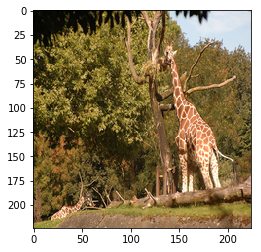

In [353]:
image_path = './data/train2014/COCO_train2014_000000000025.jpg'
image_tensor = load_image(image_path, transform).to(device)

In [354]:
image_tensor.size()

torch.Size([1, 3, 224, 224])

In [355]:
feature = encoder(image_tensor)

In [356]:
feature.size()

torch.Size([1, 256])

In [357]:
sampled_ids = decoder.sample(feature)
sampled_ids = sampled_ids[0].cpu().numpy()

In [358]:
sampled_ids.shape

(20,)

In [359]:
sampled_caption = []
for word_id in sampled_ids:
    word = vocab.idx2word[word_id]
    sampled_caption.append(word)
    if word == '<end>':
        break
sentence = ' '.join(sampled_caption)

In [360]:
sentence

'<start> a giraffe standing in a field next to a tree . <end>'